In [1]:
import os

import pandas as pd
import numpy as np

# Load data
print('Loading data...')

train = pd.read_csv(os.path.join('train.csv'))
test = pd.read_csv(os.path.join( 'test.csv'))

train_x = train.iloc[:, 1:].values.astype('float32')
train_y = train.iloc[:, 0].values.astype('int32')
test_x = test.values.astype('float32')

print('train_x', train_x.shape)
print('train_y', train_y.shape)
print('test_x', test_x.shape)

Loading data...
train_x (42000, 784)
train_y (42000,)
test_x (28000, 784)


In [2]:
train_imgs = train_x.reshape((-1, 1, 28, 28)) / 255.
test_imgs = test_x.reshape((-1, 1, 28, 28)) / 255.
print('train_imgs', train_imgs.shape, 'test_imgs', test_imgs.shape)

train_imgs (42000, 1, 28, 28) test_imgs (28000, 1, 28, 28)


index0, label 1


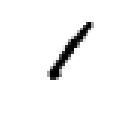

index1, label 0


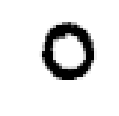

In [3]:
%matplotlib inline
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

def show_image(img):
    plt.figure(figsize=(1.5, 1.5))
    plt.axis('off')
    if img.ndim == 3:
        img = img[0, :, :]
    plt.imshow(img, cmap=plt.cm.binary)           
    plt.show()

print('index0, label {}'.format(train_y[0]))
show_image(train_imgs[0])
print('index1, label {}'.format(train_y[1]))
show_image(train_imgs[1])

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

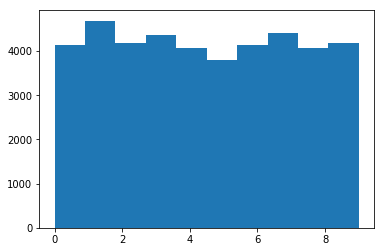

In [4]:
plt.hist(train_y)

In [5]:
import chainer
from chainer import functions as F
from chainer import initializers
from chainer import links as L
from chainer import reporter
from chainer import Variable
from chainer import datasets
from chainer import iterators

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
class DigitRecognizer(chainer.Chain):
    def __init__(self, n_class=10):
        super(DigitRecognizer, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 16, 3, 1)
            self.conv2 = L.Convolution2D(16, 32, 3, 1)
            self.conv3 = L.Convolution2D(32, 64, 3, 1)
            self.conv4 = L.Convolution2D(64, 32, 3, 1)
            self.bn1 = L.BatchNormalization(16)
            self.bn2 = L.BatchNormalization(32)
            self.bn3 = L.BatchNormalization(64)
            self.bn4 = L.BatchNormalization(32)
            self.fc = L.Linear(None, n_class)
    def __call__(self, x):
        h = F.leaky_relu(self.conv1(x))
        h = self.bn1(h)
        h = F.dropout(h, 0.5)
        h = F.leaky_relu(self.conv2(h))
        h = self.bn2(h)
        h = F.dropout(h, 0.5)
        h = F.leaky_relu(self.conv3(h))
        h = self.bn3(h)
        h = F.dropout(h, 0.5)
        h = F.leaky_relu(self.conv4(h))
        h = self.bn4(h)
        h = F.dropout(h, 0.5)
        h = self.fc(h)
        return h

In [7]:
import sklearn.model_selection
train_idx, valid_idx = sklearn.model_selection.train_test_split(np.arange(len(train_x)), test_size=0.2)
train_dataset = datasets.TupleDataset(train_imgs[train_idx], train_y[train_idx])
valid_dataset = datasets.TupleDataset(train_imgs[valid_idx], train_y[valid_idx])

In [8]:
batchsize = 128
train_iter = iterators.SerialIterator(train_dataset, batchsize)
valid_iter = iterators.SerialIterator(valid_dataset, batchsize, False, False)

In [9]:
gpu_id = 0  

net = DigitRecognizer()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

In [10]:
from chainer import training
from chainer import optimizers

gpu_id = 0  

net = L.Classifier(net)

optimizer = optimizers.SGD(lr=0.01).setup(net)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [11]:
max_epoch = 500

# TrainerにUpdaterを渡す
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [12]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [13]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.568675    0.824263       0.57386        0.82687            2.63277       
2           0.275676    0.918267       0.561811       0.833499           4.75266       
3           0.213       0.93545        0.431182       0.874124           6.88543       
4           0.184938    0.946147       0.320081       0.907576           9.03187       
5           0.165354    0.950333       0.323422       0.902178           11.1822       
6           0.148633    0.954884       0.258698       0.92339            13.3295       
7           0.140152    0.957551       0.222456       0.931203           15.5215       
8           0.132767    0.960371       0.218324       0.934991           17.6494       
9           0.120666    0.962601       0.194708       0.942732           19.7976       
10          0.116894    0.964247       0.177938       0.947751           21.9334       
11          0.107486    0.966284  

91          0.0393223   0.987375       0.0719904      0.981203           198.244       
92          0.0379822   0.987267       0.0653402      0.982102           200.408       
93          0.0365144   0.987672       0.0672138      0.981274           202.58        
94          0.0376345   0.98688        0.0739138      0.981037           204.746       
95          0.0374052   0.987672       0.0699254      0.981274           206.918       
96          0.0375535   0.987357       0.0660317      0.982339           209.083       
97          0.0374346   0.987553       0.0652559      0.982694           211.259       
98          0.0366419   0.987774       0.0682565      0.982102           213.427       
99          0.0373901   0.987464       0.0638946      0.983286           215.603       
100         0.0333842   0.988848       0.0646821      0.983168           217.773       
101         0.0349131   0.988148       0.0653744      0.982812           219.945       
102         0.0336505   0.989027

182         0.0272691   0.990249       0.0581025      0.984351           397.695       
183         0.0256675   0.991059       0.0580629      0.98518            399.884       
184         0.0260641   0.991025       0.0597979      0.984115           402.068       
185         0.025547    0.99097        0.059296       0.984706           404.257       
186         0.0261379   0.991412       0.0578657      0.985062           406.44        
187         0.0243715   0.991712       0.0571229      0.984351           408.629       
188         0.024611    0.991323       0.0577675      0.985653           410.813       
189         0.0263355   0.991118       0.0558304      0.984943           413.003       
190         0.0255924   0.991472       0.058435       0.984233           415.187       
191         0.0259977   0.990702       0.0585844      0.984943           417.379       
192         0.0258418   0.990488       0.0589226      0.984115           419.564       
193         0.0246646   0.99088 

273         0.0212186   0.992336       0.0565625      0.98518            597.866       
274         0.0201654   0.993321       0.0557783      0.985369           600.046       
275         0.0204349   0.99296        0.0558085      0.985724           602.234       
276         0.021976    0.992038       0.054665       0.985535           604.414       
277         0.0187574   0.993613       0.0563902      0.985961           606.602       
278         0.0208279   0.992665       0.054216       0.985772           608.781       
279         0.0193092   0.993198       0.0537963      0.9866             610.968       
280         0.0207913   0.992605       0.0586945      0.986245           613.148       
281         0.020951    0.992395       0.0547369      0.986719           615.338       
282         0.0187466   0.993768       0.0559242      0.985653           617.518       
283         0.0201742   0.993079       0.0561746      0.9866             619.705       
284         0.0210763   0.992873

364         0.0162519   0.994096       0.0543952      0.98679            798.29        
365         0.0159139   0.994594       0.0545885      0.987027           800.491       
366         0.0156609   0.994305       0.0542126      0.986316           802.685       
367         0.0179057   0.993376       0.0539866      0.987074           804.885       
368         0.0175191   0.9935         0.0554836      0.98608            807.079       
369         0.0176641   0.993287       0.0567466      0.986435           809.28        
370         0.0167383   0.993828       0.0525901      0.986837           811.474       
371         0.0176303   0.99391        0.0547473      0.9866             813.675       
372         0.0163772   0.994036       0.0519239      0.987027           815.868       
373         0.0157072   0.994505       0.0549868      0.986245           818.069       
374         0.0171655   0.993977       0.0546524      0.986482           820.263       
375         0.0173081   0.993554

455         0.0155072   0.994148       0.0562902      0.986719           999.33        
456         0.0147558   0.99502        0.0544285      0.986837           1001.52       
457         0.015196    0.994445       0.0550003      0.987192           1003.71       
458         0.014208    0.994871       0.0549169      0.986837           1005.9        
459         0.0158913   0.994475       0.0535985      0.986955           1008.1        
460         0.0139492   0.99514        0.0561645      0.9866             1010.29       
461         0.0149257   0.994772       0.0569276      0.986245           1012.49       
462         0.0163639   0.994543       0.0550041      0.986482           1014.68       
463         0.0156337   0.994386       0.0545974      0.986955           1016.87       
464         0.0150781   0.994722       0.0548081      0.987311           1019.06       
465         0.0164083   0.994148       0.0534121      0.987429           1021.26       
466         0.0145624   0.99505 

In [19]:
infer_net = DigitRecognizer()
from chainer import serializers
serializers.load_npz('mnist_result/snapshot_epoch-500', infer_net, path='updater/model:main/predictor/')

In [20]:
infer_net.to_gpu(gpu_id)

In [28]:
x= test_imgs
#plt.imshow(x.reshape(28, 28), cmap='gray')
#plt.show()

x = infer_net.xp.asarray(x)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)
y = chainer.cuda.to_cpu(y.array)

print(y.shape)

(28000, 10)
予測ラベル: 9


In [29]:
def create_submission(submission_path, t):
    result_dict = {
        'ImageId': np.arange(1, len(t) + 1),
        'Label': t
    }
    df = pd.DataFrame(result_dict)
    df.to_csv(submission_path,
              index_label=False, index=False)
    print('submission file saved to {}'.format(submission_path))

In [31]:
create_submission('submission_simple.csv', y.argmax(axis=1))

submission file saved to submission_simple.csv
